In [1]:
import sys
import os
import platform
import importlib
import glob

import numpy as np
import pandas as pd
import netCDF4
import datetime

if platform.system() == 'Darwin':  # macOS
    base_FP = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive'
    sys.path.append(base_FP + '/python_modules')
    nc_save_dir = '/Users/hyunglokkim/cpuserver_data'
else:
    base_FP = '/home/h/Insync/hkim@geol.sc.edu/Google Drive'
    sys.path.append(base_FP + '/python_modules')
    nc_save_dir = '/data'
    
import hydroAI.SMOS_IC as hSMOS_IC
import hydroAI.ASCAT_TUW as hASCAT_TUW
import hydroAI.Plot as Plot
import hydroAI.Data as Data
importlib.reload(hSMOS_IC);
importlib.reload(hASCAT_TUW);
importlib.reload(Data);
import warnings

# Ignore runtime warnings
warnings.filterwarnings("ignore")

In [2]:
def extract_filelist_doy(directory, year):
    data = []

    # Iterate over the subdirectories within the specified directory
    for subdir in os.listdir(directory):
        sub_dir_path = os.path.join(directory, subdir)
        
        # Check if the item is a directory and matches the 'yyyy.mm.dd' format
        if os.path.isdir(sub_dir_path) and len(subdir) == 10 and subdir[4] == '.' and subdir[7] == '.':
            # Convert the 'yyyy.mm.dd' format to 'yyyy-mm-dd'
            date_str = '-'.join(subdir.split('.'))
            # Convert the date string to a datetime object
            date_obj = datetime.datetime.strptime(date_str, '%Y-%m-%d')

            # Process only if the year matches the specified year
            if date_obj.year == year:
                # Search for .h5 files within the subdirectory
                h5_files = glob.glob(os.path.join(sub_dir_path, '*.h5'))

                # Get the day of the year (DOY) number
                doy = date_obj.timetuple().tm_yday

                # Append file paths and corresponding DOY to the data list
                for file in h5_files:
                    data.append((file, doy))

    # Sort the data list based on DOY (and date)
    data.sort(key=lambda x: x[1])

    # Unzip the sorted data into separate lists
    file_list, data_doy = zip(*data) if data else ([], [])

    return file_list, data_doy

def get_e2grid(cpuserver_data_FP, mission_product):
    if mission_product.startswith('SPL3SMP.'):
        grid_prefix = 'EASE2_M36km'
        shape = (964, 406)
    elif mission_product.startswith('SPL3SMP_E.'):
        grid_prefix = 'EASE2_M09km'
        shape = (3856, 1624)
    else:
        return None, None  # or some default value, or raise an error

    # Construct file paths for latitude and longitude
    # File names use shape in the order (lat_size, lon_size)
    grid_size = f"{shape[0]}x{shape[1]}x1"
    lats_FP = os.path.join(cpuserver_data_FP, f'grids/{grid_prefix}.lats.{grid_size}.double')
    lons_FP = os.path.join(cpuserver_data_FP, f'grids/{grid_prefix}.lons.{grid_size}.double')

    # Load and reshape data
    # Reshape uses flipped dimensions (lon_size, lat_size)
    latitude = np.fromfile(lats_FP, dtype=np.float64).reshape((shape[1], shape[0]))
    longitude = np.fromfile(lons_FP, dtype=np.float64).reshape((shape[1], shape[0]))

    return longitude, latitude

In [3]:
import calendar
import h5py
from tqdm import tqdm
from ease_grid import EASE2_grid

def create_array_from_h5(file_list, data_doy, year, cpuserver_data_FP, mission_product, variable_name, group_name):
    x, y = None, None
    doy_max = 366 if calendar.isleap(year) else 365

    # Initialize data_array with NaNs
    data_array = None

    # Loop over the file list with a progress bar
    for i, h5_file in enumerate(tqdm(file_list, desc="Processing files", unit="file")):
        try:
            with h5py.File(h5_file, 'r') as hdf5_data:
                dataset = hdf5_data[group_name][variable_name]
                
                if data_array is None:
                    # Get the shape of dataset from the first file
                    x, y = dataset[:].shape
                    data_array = np.full((x, y, doy_max + 1), np.nan)  # Create the array filled with NaN

                t_data = dataset[:].astype(np.float64)

                # Get attributes and apply them if they exist
                fill_value = np.float64(dataset.attrs.get('_FillValue', np.nan))
                valid_min = np.float64(dataset.attrs.get('valid_min', -np.inf))
                valid_max = np.float64(dataset.attrs.get('valid_max', np.inf))
                scale_factor = np.float64(dataset.attrs.get('scale_factor', 1.0))
                add_offset = np.float64(dataset.attrs.get('add_offset', 0.0))

                # Apply scale and offset if applicable
                if 'scale_factor' in dataset.attrs or 'add_offset' in dataset.attrs:
                    t_data = t_data * scale_factor + add_offset

                # Mask invalid data
                t_data = np.where((t_data < valid_min) | (t_data > valid_max) | (t_data == fill_value), np.nan, t_data)

                # Get the corresponding doy value from the data_doy list
                doy = data_doy[i]

                # Assign the data to the array
                data_array[:, :, doy] = t_data

        except OSError as e:
            print(f"Error processing file {h5_file}: {e}")
            if data_array is not None and x is not None and y is not None:
                # Mark the entire day as NaN in case of an error
                data_array[:, :, data_doy[i]] = np.nan

    # Get EASE2 lat/lon from the get_e2grid function
    longitude, latitude = get_e2grid(cpuserver_data_FP, mission_product)
    
    return data_array, longitude, latitude

In [4]:
def create_netcdf_file(nc_file, latitude, longitude, **data_vars):
    # Create a new NetCDF file
    nc_data = netCDF4.Dataset(nc_file, 'w')

    # Define the dimensions
    rows, cols = latitude.shape
    # Assuming all data variables have the same 'time' dimension size
    doy = next(iter(data_vars.values())).shape[2]

    # Create dimensions in the NetCDF file
    nc_data.createDimension('latitude', rows)
    nc_data.createDimension('longitude', cols)
    nc_data.createDimension('doy', doy)

    # Create latitude and longitude variables
    lat_var = nc_data.createVariable('latitude', 'f4', ('latitude', 'longitude'))
    lon_var = nc_data.createVariable('longitude', 'f4', ('latitude', 'longitude'))

    # Assign data to the latitude and longitude variables
    lat_var[:] = latitude
    lon_var[:] = longitude

    # Create variables and assign data for each item in data_vars
    for var_name, var_data in data_vars.items():
        # Create variable in NetCDF file
        nc_var = nc_data.createVariable(var_name, 'f4', ('latitude', 'longitude', 'doy'))
        # Assign data to the variable
        nc_var[:] = var_data

    # Close the NetCDF file
    nc_data.close()

    print(f"NetCDF file {nc_file} created successfully.")

In [5]:
# Usage example
cpuserver_data_FP = '/Users/hyunglokkim/cpuserver_data'
nc_save_dir = 'extracted_nc'
mission = 'SMAP'
mission_product = 'SPL3SMP_E.005'
year = 2022
directory = os.path.join(cpuserver_data_FP, mission, mission_product)
file_list, data_doy = extract_filelist_doy(directory, year) 
longitude, latitude = get_e2grid(cpuserver_data_FP, mission_product)

In [ ]:
# Usage example - create_array_from_h5
group_name = 'Soil_Moisture_Retrieval_Data_AM'
variable_name = 'soil_moisture'
SMAP_SM_AM, longitude, latitude = create_array_from_h5(file_list, data_doy, year, cpuserver_data_FP,mission_product, variable_name, group_name)
variable_name = 'retrieval_qual_flag'
SMAP_QF_AM, longitude, latitude = create_array_from_h5(file_list, data_doy, year, cpuserver_data_FP,mission_product, variable_name, group_name)
variable_name = 'tb_qual_flag_3'
SMAP_tb3_flag_AM, longitude, latitude = create_array_from_h5(file_list, data_doy, year, cpuserver_data_FP,mission_product, variable_name, group_name)
variable_name = 'tb_qual_flag_4'
SMAP_tb4_flag_AM, longitude, latitude = create_array_from_h5(file_list, data_doy, year, cpuserver_data_FP,mission_product, variable_name, group_name)
variable_name = 'soil_moisture_error' 
SMAP_SM_error_AM, longitude, latitude = create_array_from_h5(file_list, data_doy, year, cpuserver_data_FP,mission_product, variable_name, group_name)
variable_name = 'vegetation_water_content' 
SMAP_VWC_AM, longitude, latitude = create_array_from_h5(file_list, data_doy, year, cpuserver_data_FP,mission_product, variable_name, group_name)

In [ ]:
# Usage example - create_netcdf_file
# SMAPL3 AM
nc_file_name = os.path.join(cpuserver_data_FP,nc_save_dir)+'/'+mission_product+'_'+str(year)+'_am.nc'

create_netcdf_file(
    nc_file=nc_file_name, 
    latitude=latitude, 
    longitude=longitude, 
    SMAP_SM_AM=SMAP_SM_AM,
    SMAP_QF_AM=SMAP_QF_AM,
    SMAP_tb3_flag_AM=SMAP_tb3_flag_AM,
    SMAP_tb4_flag_AM=SMAP_tb4_flag_AM,
    SMAP_SM_error_AM=SMAP_SM_error_AM,
    SMAP_VWC_AM=SMAP_VWC_AM
)

In [ ]:
# Loop through everything from 2015 to 2023 for AM/PM data
cpuserver_data_FP = '/Users/hyunglokkim/cpuserver_data'
mission = 'SMAP'
mission_product = 'SPL3SMP.008'
nc_save_dir = 'extracted_nc'

# Ensure the directory for saving NetCDF files exists
os.makedirs(os.path.join(cpuserver_data_FP, nc_save_dir), exist_ok=True)

# Variables to process
variables = [
    'soil_moisture',
    'retrieval_qual_flag',
    'tb_qual_flag_3',
    'tb_qual_flag_4',
    'soil_moisture_error',
    'vegetation_water_content'
]

for year in range(2015, 2024):
    directory = os.path.join(cpuserver_data_FP, mission, mission_product)
    file_list, data_doy = extract_filelist_doy(directory, year)
    longitude, latitude = get_e2grid(cpuserver_data_FP, mission_product)

    # Loop for AM and PM
    for suffix in ['AM', 'PM']:
        group_name = f'Soil_Moisture_Retrieval_Data_{suffix}'

        # Collect data for each variable
        data_vars = {}
        for var in variables:
            variable_name = f"{var}_{suffix.lower()}" if suffix == 'PM' else var
            data, _, _ = create_array_from_h5(file_list, data_doy, year, cpuserver_data_FP, mission_product, variable_name, group_name)
            data_vars[variable_name] = data
        
        # Save to NetCDF file
        nc_file_name = os.path.join(cpuserver_data_FP, nc_save_dir, f'{mission_product}_{year}_{suffix.lower()}.nc')
        create_netcdf_file(nc_file=nc_file_name, latitude=latitude, longitude=longitude, **data_vars)
        print(f"Data for {year} {suffix} saved to {nc_file_name}")

In [ ]:
# Display the image
nanmean_SMAP_SM_AM = np.nanmean(SMAP_SM_AM, axis=2)
target = nanmean_SMAP_SM_AM
Plot.plot_global_map(longitude, latitude, target, 'SM', np.nanmin(target), np.nanmax(target), 'jet_r')

In [ ]:
def check_flags(value, flag_value):
    return (value & flag_value) == flag_value

# Example usage:
value = 65534  # This is the value you got from the 'tb_qual_flag_4' dataset
flag_masks = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 4096, 16384, 32768]

flag_meanings = [
    "4th_Stokes_quality",
    "4th_Stokes_range",
    "4th_Stokes_RFI_detection",
    "4th_Stokes_RFI_correction",
    "4th_Stokes_NEDT",
    "4th_Stokes_direct_sun_correction",
    "4th_Stokes_reflected_sun_correction",
    "4th_Stokes_reflected_moon_correction",
    "4th_Stokes_direct_galaxy_correction",
    "4th_Stokes_reflected_galaxy_correction",
    "4th_Stokes_atmosphere_correction",
    "4th_Stokes_null_value_bit",
    "4th_Stokes_RFI_check",
    "4th_Stokes_RFI_clean"
]

for flag, meaning in zip(flag_masks, flag_meanings):
    if check_flags(value, flag):
        print(f"{meaning} flag is set")
    else:
        print(f"{meaning} flag is not set")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

# Constants
seoul_coords = (37.5665, 126.9780)
rfi_flag_mask = 4  # Replace with the actual mask value for RFI detection
nan_placeholder = -1  # An integer placeholder for NaN values

# Function to find the closest index
def find_closest_index(latitudes, longitudes, point):
    lat_lon = np.c_[latitudes.ravel(), longitudes.ravel()]
    tree = cKDTree(lat_lon)
    dist, idx = tree.query(point, k=1)
    return np.unravel_index(idx, latitudes.shape)

# Find the closest pixel to Seoul
closest_pixel_index = find_closest_index(latitude, longitude, seoul_coords)

# Extract the time series of SMAP_tb4_flag values for the closest pixel
tb4_flag_timeseries = SMAP_tb4_flag[closest_pixel_index[0], closest_pixel_index[1], :]

# Replace NaN values with the placeholder, and ensure data is an integer type
tb4_flag_timeseries_nonan = np.nan_to_num(tb4_flag_timeseries, nan=nan_placeholder).astype(np.int64)

# Initialize rfi_detected array with zeros (no RFI detected by default)
rfi_detected = np.zeros(tb4_flag_timeseries_nonan.shape, dtype=float)

# Check if RFI is detected (bitwise operation), and mark it as 1 in rfi_detected
rfi_detected[(tb4_flag_timeseries_nonan & rfi_flag_mask) == rfi_flag_mask] = 1

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(rfi_detected, label='RFI Detection Status', linestyle='-', marker='o', markersize=4)
plt.xlabel('Time')
plt.ylabel('RFI Detection (1: Detected, 0: Not Detected)')
plt.title(f'RFI Detection over Time for Pixel Closest to Seoul, Korea')
plt.legend()
plt.grid(True)
plt.ylim(-0.1, 1.1)  # Set y-axis limits to make peaks more visible
plt.show()


# 1. Import SMOS_IC

In [ ]:
# Run this line if there is only tar files.
root_dir = os.path.join(cpuserver_data_FP, 'SMOS_IC')

#for year in [2015, 2022]:
#    hSMOS_IC.extract_tgz_files(root_dir, year)

In [ ]:
path_list = ['A', 'D']
for year in range(2022, 2023):  # Looping from 2015 to 2021
    for path in path_list:
        print(year, path)
        directory = os.path.join(root_dir, path, str(year))
        file_list, data_doy = hSMOS_IC.extract_filelist_doy(directory)

        # Import Variables
        SMOS_SM, longitude, latitude = hSMOS_IC.create_array_from_nc(file_list, data_doy, year, 'Soil_Moisture')
        SMOS_SM[SMOS_SM<=0] = np.nan
        SMOS_RFI = hSMOS_IC.create_array_from_nc(file_list, data_doy, year, 'Rfi_Prob')[0]
        SMOS_SF  = hSMOS_IC.create_array_from_nc(file_list, data_doy, year, 'Science_Flags')[0]

        # Create a NetCDF file
        path_time = 'am' if path == 'A' else 'pm'
        
        file_name = f'SMOS_IC_{year}_{path_time}.nc'
        nc_file = os.path.join(cpuserver_data_FP, nc_save_dir, file_name)
                     
        hSMOS_IC.create_netcdf_file(nc_file, latitude, longitude, SMOS_SM, SMOS_RFI, SMOS_SF)

        print(f"NetCDF file created: {nc_file}")

In [ ]:
# Display the image
nanmean_SMOS_SM  = np.nanmean(SMOS_SM, axis=2)
nanmean_SMOS_RFI = np.nanmean(SMOS_RFI, axis=2)
target = nanmean_SMOS_RFI
Plot.plot_global_map(longitude, latitude, target, 'SM', 0, 1, 'jet_r')

# 2. Import ASCAT from mat files

In [ ]:
root_dir = cpuserver_data_FP+'/mat_files/ASCAT_h119_120/'

for year in range(2015, 2022):
    path_list = ['am', 'pm']
    for path in path_list:
        mat_file = root_dir + str(year) + '_ASCAT_SM_' + path + '_QC.mat'
        ASCAT_SM, latitude, longitude = hASCAT_TUW.load_mat_file(mat_file, path)
        file_name = 'ASCAT_TUW_'+str(year)+'_'+path+'.nc'
        print(file_name)
        nc_file = os.path.join(cpuserver_data_FP, 'extracted_nc')+'/'+file_name
        hASCAT_TUW.create_netcdf_file(nc_file, latitude, longitude, ASCAT_SM)

In [ ]:
#nanmean_ASCAT_SM = np.nanmean(ASCAT_SM_am, axis=2)
#target = nanmean_ASCAT_SM
Plot.plot_global_map(longitude, latitude, target, 'SM', 0, 10000, 'jet_r')

# 3. Resample SMOS and ASCAT data

### 3.1. Load the domain lat/lon

In [6]:
#domain_nc_file = base_FP+'/Lab/2023_DA_TCA/libs/lis_input_noah33.nc'
#nc_data = netCDF4.Dataset(domain_nc_file)
#domain_lat = np.flipud(nc_data.variables['lat'][:]).data
#domain_lon = np.flipud(nc_data.variables['lon'][:]).data
#nc_data.close()
cpuserver_data_FP = '/Users/hyunglokkim/cpuserver_data'
nc_save_dir = 'extracted_nc'
mission_product = 'SPL3SMP_E.005'
domain_lon, domain_lat = get_e2grid(cpuserver_data_FP, mission_product)

### 3.2. Resample SMOS

In [ ]:
for year in range(2016, 2023):
    path_list = ['am', 'pm']
    
    for path in path_list:
        # resample SMOS into the doamin size
        nc_file  = nc_save_dir+'/extracted_nc/SMOS_IC_'+str(year)+'_'+path+'.nc'
        nc_data  = netCDF4.Dataset(nc_file)
        SMOS_SM  = nc_data.variables['SMOS_SM'][:].data
        SMOS_RFI = nc_data.variables['SMOS_RFI'][:].data
        #SMOS_SF  = nc_data.variables['SMOS_SF'][:].data
        SMOS_lat = nc_data.variables['latitude'][:].data
        SMOS_lon = nc_data.variables['longitude'][:].data
        nc_data.close()
    
        Resampled_SMOS_SM  = Data.Resampling_forloop(domain_lat, domain_lon, SMOS_lat, SMOS_lon, SMOS_SM)
        Resampled_SMOS_RFI = Data.Resampling_forloop(domain_lat, domain_lon, SMOS_lat, SMOS_lon, SMOS_RFI)
        #Resampled_SMOS_SF  = Data.Resampling_parallel(domain_lat, domain_lon, SMOS_lat, SMOS_lon, SMOS_SF, 'nearest', 'mode',3) #too slow
        #We may need to apply RFI/SF first and resample SM
        file_name = 'SMOS_IC_'+str(year)+'_'+path+'_R_'+mission_product+'.nc'
        nc_file = os.path.join(nc_save_dir, 'extracted_nc')+'/'+file_name
        hSMOS_IC.create_netcdf_file(nc_file, domain_lat, domain_lon, Resampled_SMOS_SM, Resampled_SMOS_RFI)

In [ ]:
# Check if Resampling fun in Data works
doy = 100
r_smos = Resampled_SMOS_SM[:,:,doy]
Plot.plot_global_map(domain_lon, domain_lat, r_smos, 'or_SM', 0, 0.5, 'jet_r')
smos = SMOS_SM[:,:,doy]
Plot.plot_global_map(SMOS_lon, SMOS_lat, smos, 're_SM', 0, 0.5, 'jet_r')

### 3.3. Resample ASCAT

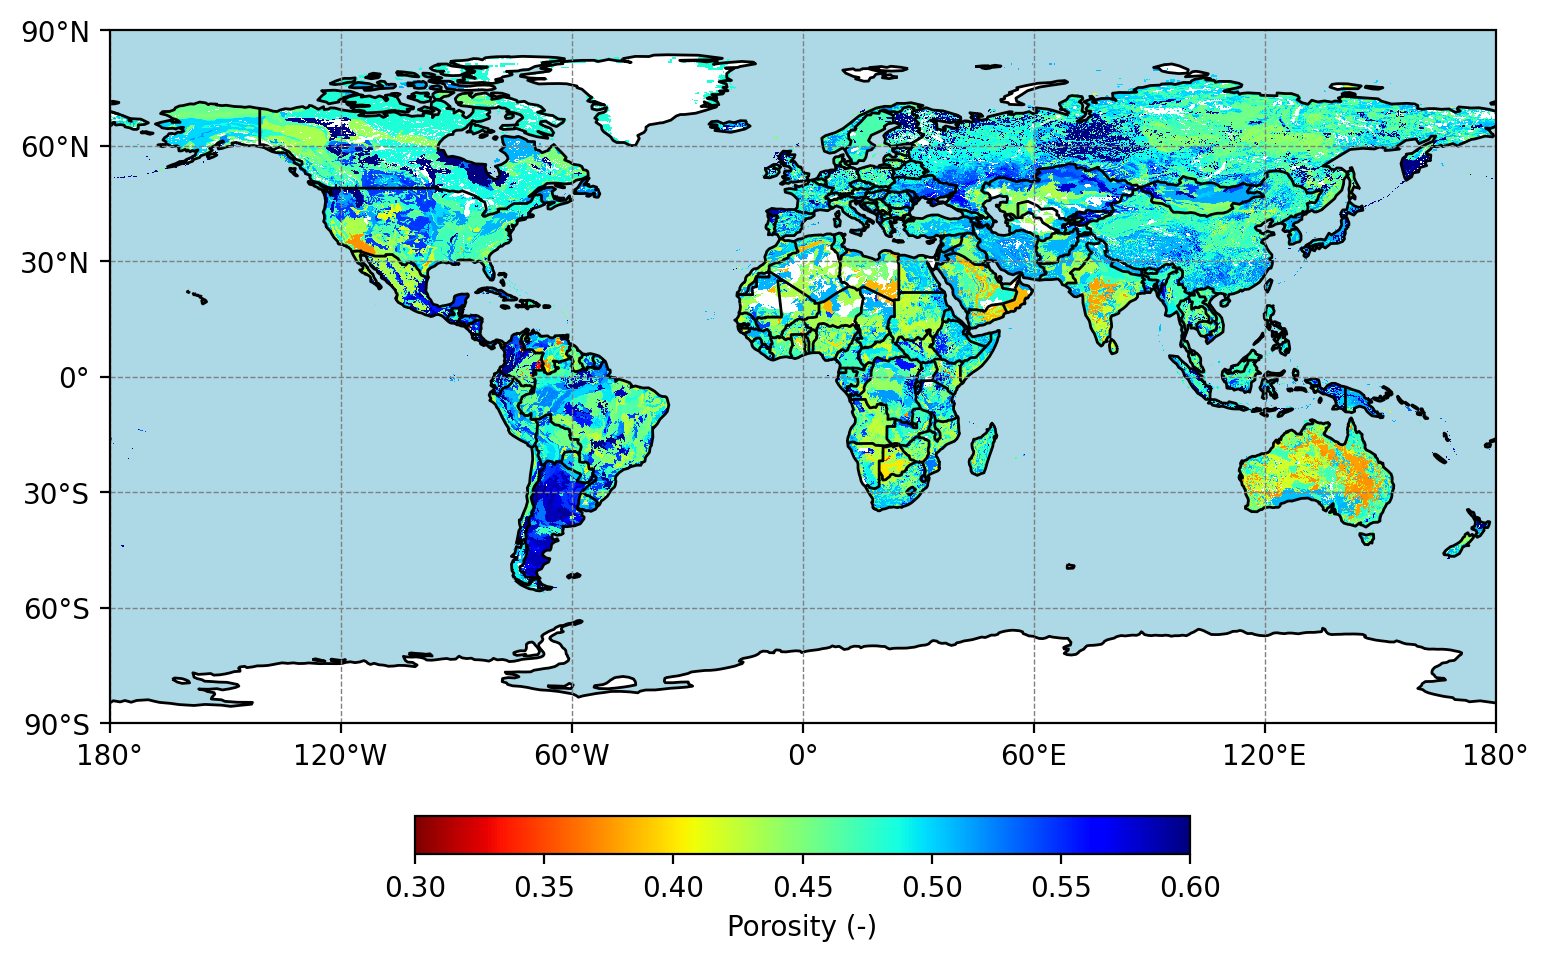

In [7]:
#import porosity
porosity_EASE9_mat_file  = cpuserver_data_FP+'/mat_files/soil_climate_etc/world_PORO_EASE_009.mat'
ease_grid_EASE9_mat_file = cpuserver_data_FP+'/mat_files/ease_grid_files/ease_lat_lon_9km.mat'

poro_EASE9 = hASCAT_TUW.load_porosity_mat(porosity_EASE9_mat_file)['PORO']
lat_EASE9 = hASCAT_TUW.load_porosity_mat(ease_grid_EASE9_mat_file)['ease_lat_9km']
lon_EASE9 = hASCAT_TUW.load_porosity_mat(ease_grid_EASE9_mat_file)['ease_lon_9km']

Plot.plot_global_map(lon_EASE9, lat_EASE9, poro_EASE9, 'Porosity (-)', 0.3, 0.6, 'jet_r')

In [23]:
from scipy.interpolate import griddata
#import subsurface scattering
cpuserver_data_FP = '/Users/hyunglokkim/cpuserver_data'
nc_save_dir = 'extracted_nc'
mission_product = 'SPL3SMP.008'

nc_file = os.path.join(cpuserver_data_FP, 'ASCAT', 'subsurface_scattering_ASCAT_ERA5_Land.nc')
nc_data = netCDF4.Dataset(nc_file)
subano = nc_data.variables['S_sub'][:].data
lat_subano = nc_data.variables['lat'][:].data
lon_subano = nc_data.variables['lon'][:].data

domain_lon, domain_lat = get_e2grid(cpuserver_data_FP, mission_product)

# Flatten the 2D grid for the interpolation function
# Ensure the input for griddata is in the correct shape
points = np.column_stack((lon_subano, lat_subano))
grid_z = griddata(points, subano, (domain_lon, domain_lat), method='nearest')  # or method='linear', 'cubic'

hASCAT_TUW.create_netcdf_file(os.path.join(cpuserver_data_FP, nc_save_dir, 'S_sub_R_'+mission_product+'.nc'), domain_lat, domain_lon, grid_z, var_name='S_sub')

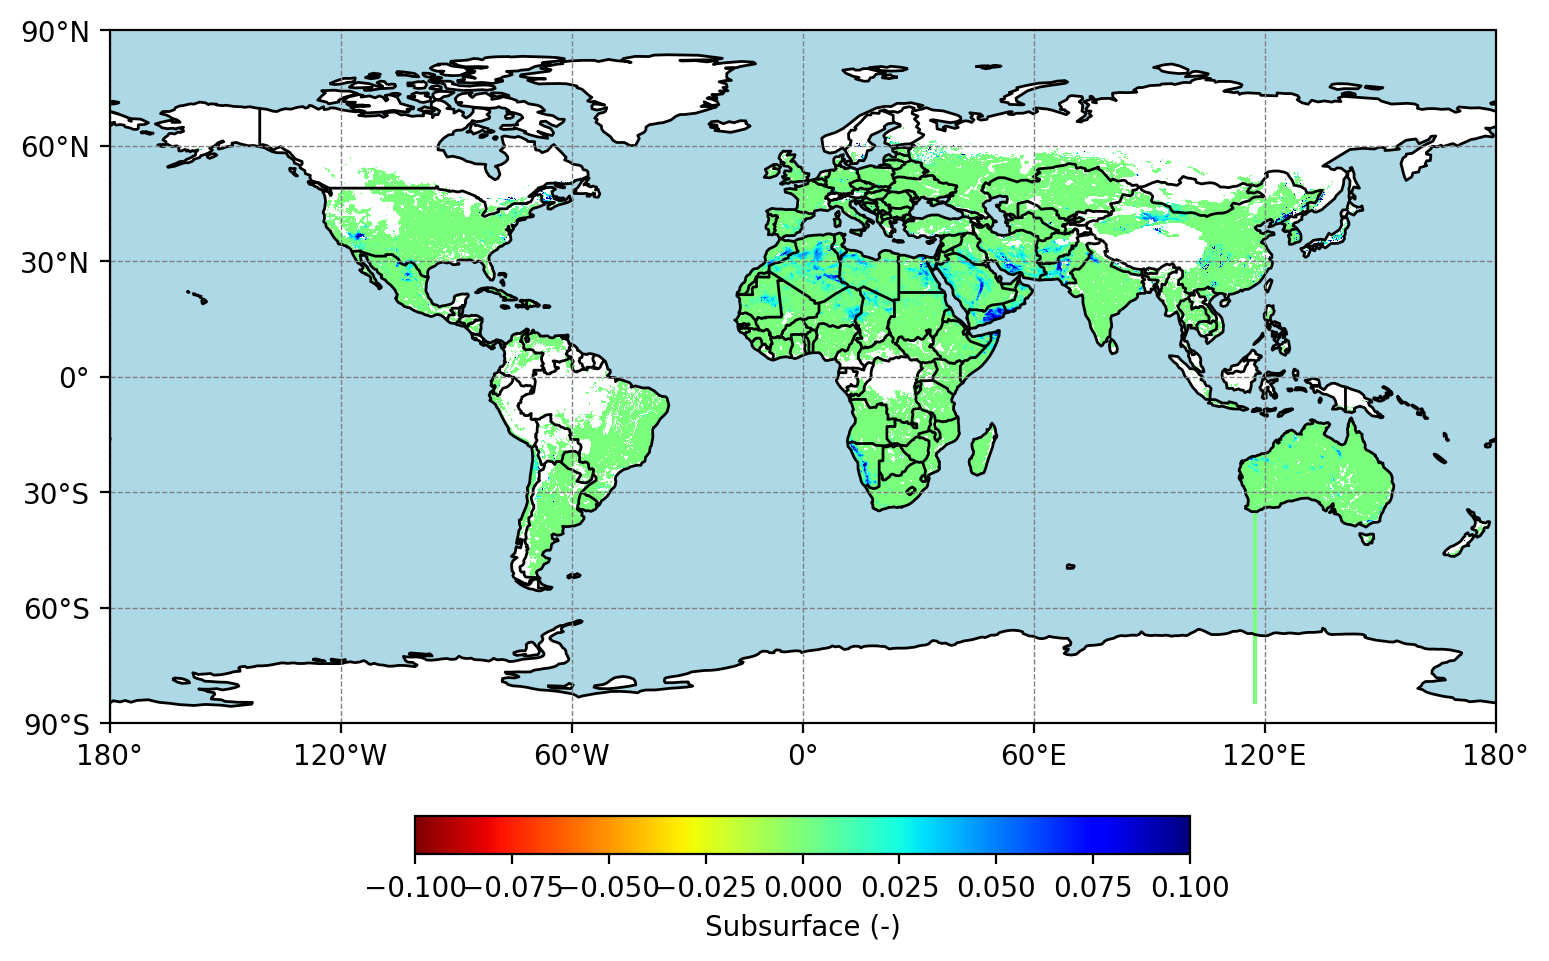

In [18]:
Plot.plot_global_map(domain_lon, domain_lat, grid_z, 'Subsurface (-)', np.min(grid_z), np.max(grid_z), 'jet_r')

In [ ]:
# Resample SM
for year in range(2015, 2023):
    path_list = ['am', 'pm']
    for path in path_list:
        # resample ASCAT into the doamin size
        nc_file  = nc_save_dir+'/extracted_nc/ASCAT_TUW_'+str(year)+'_'+path+'.nc'
        nc_data  = netCDF4.Dataset(nc_file)
        ASCAT_SM  = nc_data.variables['ASCAT_SM'][:].data
        ASCAT_lat = nc_data.variables['latitude'][:].data
        ASCAT_lon = nc_data.variables['longitude'][:].data
        nc_data.close()
        print('data_loaded')
        Resampled_ASCAT_SM  = Data.Resampling_forloop(domain_lat, domain_lon, ASCAT_lat, ASCAT_lon, ASCAT_SM, 'nearest','mean', 1)
        
        file_name = 'ASCAT_IC_'+str(year)+'_'+path+'_R_'+mission_product+'.nc'
        nc_file = os.path.join(nc_save_dir, 'extracted_nc')+'/'+file_name
        hASCAT_TUW.create_netcdf_file(nc_file, domain_lat, domain_lon, Resampled_ASCAT_SM)

In [ ]:
# Resample porosity
importlib.reload(hASCAT_TUW)
Resampled_poro = Data.Resampling(domain_lat, domain_lon, lat_EASE9, lon_EASE9, poro_EASE9, sampling_method='nearest', agg_method='mean', mag_factor=2) 
nc_file  = nc_save_dir+'/extracted_nc/PORO_R_'+mission_product+'.nc'
hASCAT_TUW.create_netcdf_file(nc_file, domain_lat, domain_lon, Resampled_poro, 'Porosity')

r_poro = Resampled_poro
Plot.plot_global_map(domain_lon, domain_lat, r_poro, 'r_Porosity (-)', 0.3, 0.6, 'jet_r')
Plot.plot_global_map(lon_EASE9, lat_EASE9, poro_EASE9, 'or_Porosity (-)', 0.3, 0.6, 'jet_r')

In [ ]:
# Check if Resampling fun in Data works
doy = 203
r_ascat = Resampled_ASCAT_SM[:,:,doy]
Plot.plot_global_map(domain_lon, domain_lat, r_ascat, 'r_SWI(-)', 0, 10000, 'jet_r')
ascat = ASCAT_SM[:,:,doy]
Plot.plot_global_map(ASCAT_lon, ASCAT_lat, ascat, 'or_SWI(-)', 0, 10000, 'jet_r')

#np.nanmax(r_ascat)

In [ ]:
import platform
import sys
import datetime
import netCDF4
import numpy as np

if platform.system() == 'Darwin':
    base_FP = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive'
    sys.path.append(base_FP + '/python_modules')
    nc_save_dir = '/Volumes/rapid'
else:
    base_FP = '/home/h/Insync/hkim@geol.sc.edu/Google Drive'
    sys.path.append(base_FP + '/python_modules')
    nc_save_dir = '/media/h/06BEFF93BEFF798F/data'

import hydroAI.TC_like as TCL
import hydroAI.Plot as Plot
import hydroAI.Data as Data
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### 4. Load resampled data, select time-period, and convert ASCAT SWI to VSM. 

### 4.1. Stduy domain

In [ ]:
domain_nc_file = base_FP+'/Lab/2023_DA_TCA/libs/lis_input_noah33.nc'
nc_data = netCDF4.Dataset(domain_nc_file)
domain_lat = np.flipud(nc_data.variables['lat'][:]).data
domain_lon = np.flipud(nc_data.variables['lon'][:]).data
nc_data.close()

### 4.2. Specify the time-period.

In [ ]:
start_date = datetime.datetime(2022, 4, 1)
end_date   = datetime.datetime(2022, 4, 30)

# Calculate the day of year values
doy1 = start_date.timetuple().tm_yday
doy2 = end_date.timetuple().tm_yday

In [ ]:
nc_file_Porosity = nc_save_dir+'/extracted_nc/PORO_R_Noah_025.nc'
nc_data_PORO   = netCDF4.Dataset(nc_file_Porosity)
Porosity       = nc_data_PORO.variables['Porosity'][:].data

m, n = Porosity.shape; z = doy2-doy1+1

path_list = ['am', 'pm']
RFI_th = 0.9

#combined the am and pm data sets
ASCAT_SM_am_pm = np.zeros((m, n, z*2), dtype='float64')
SMOS_SM_am_pm  = np.zeros((m, n, z*2), dtype='float64')

for path in path_list:
    nc_file_SMOS   = nc_save_dir+'/extracted_nc/SMOS_IC_2022_'+path+'_R_Noah_025.nc'
    nc_file_ASCAT  = nc_save_dir+'/extracted_nc/ASCAT_TUW_2022_'+path+'_R_Noah_025.nc'

    nc_data_SMOS = netCDF4.Dataset(nc_file_SMOS)
    SMOS_SM      = nc_data_SMOS.variables['SMOS_SM'][:].data
    SMOS_RFI     = nc_data_SMOS.variables['SMOS_RFI'][:].data
    SMOS_SM[SMOS_RFI>RFI_th] = np.nan
    sub_SMOS_SM  = SMOS_SM[:,:, doy1:doy2+1]

    nc_data_ASCAT = netCDF4.Dataset(nc_file_ASCAT)
    ASCAT_SWI     = nc_data_ASCAT.variables['ASCAT_SM'][:].data
    sub_ASCAT_SM  = ASCAT_SWI[:,:, doy1-1:doy2]/10000*np.expand_dims(Porosity, axis=2)

    if path == 'am':
        SMOS_SM_am_pm[:, :,  ::2]  = sub_SMOS_SM
        ASCAT_SM_am_pm[:, :, ::2]  = sub_ASCAT_SM
    else:
        SMOS_SM_am_pm[:, :, 1::2]  = sub_SMOS_SM
        ASCAT_SM_am_pm[:, :, 1::2] = sub_ASCAT_SM

In [ ]:
ma_SMOS_SM_am_pm  = Data.moving_average_3d(SMOS_SM_am_pm, 5)
ma_ASCAT_SM_am_pm = Data.moving_average_3d(ASCAT_SM_am_pm, 5)

# pseudo DA_SM data. Generated from the ASCAT SM data with white noise.
temp_error = np.random.normal(loc=0, scale=0.05, size=(m, n, z*2))
DA_SM      = ASCAT_SM_am_pm + temp_error
ma_DA_SM   = Data.moving_average_3d(DA_SM, 5)

In [ ]:
# Check the moving-averaged SM vs originia SM data sets
t1 = np.sum(ma_SMOS_SM_am_pm>0,2)
t2 = np.sum(ma_ASCAT_SM_am_pm>0,2)
row_indices, col_indices = np.where((t1 > 20) & (t2 > 20))
idx = 1305

plt.plot(ma_SMOS_SM_am_pm[row_indices[idx], col_indices[idx],:],'-o', label='ma_SMOS')
plt.plot(SMOS_SM_am_pm[row_indices[idx], col_indices[idx],:], '-o', label='or_SMOS')

plt.plot(ma_ASCAT_SM_am_pm[row_indices[idx], col_indices[idx],:],'-o', label='ma_ASCAT')
plt.plot(ASCAT_SM_am_pm[row_indices[idx], col_indices[idx],:], '-o', label='or_ASCAT')

plt.plot(ma_DA_SM[row_indices[idx], col_indices[idx],:],'-o', label='ma_DA_SM')
plt.plot(DA_SM[row_indices[idx], col_indices[idx],:], '-o', label='or_DA_SM')

plt.legend()
plt.grid()
plt.ylabel(r'VSM ($\frac{m^3}{m^3}$)');

### 4.3 Calcuate the TC numbers

In [ ]:
D1 = ma_SMOS_SM_am_pm
D2 = ma_ASCAT_SM_am_pm
D3 = ma_DA_SM
fMSE = TCL.TCA(D1, D2, D3, nod_th=20, corr_th=0.1, REF=None)[4]

### 4.3 Check the results

In [ ]:
SMOS_fMSE  = fMSE['x'] #the lower the better
ASCAT_fMSE = fMSE['y'] #the lower the better
DA_fMSE    = fMSE['z'] #the lower the better

Plot.plot_global_map(domain_lon, domain_lat, SMOS_fMSE, 'SMOS fMSE(-)', 0, 1, 'jet')
Plot.plot_global_map(domain_lon, domain_lat, ASCAT_fMSE, 'ASCAT fMSE(-)', 0, 1, 'jet')
Plot.plot_global_map(domain_lon, domain_lat, DA_fMSE, 'DA fMSE(-)', 0, 1, 'jet')